In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

from sklearn import linear_model


## Predictor Variables

In [2]:
# Commodity Prices
dfCommodity = pd.read_csv('../data/commodityPrices.csv')
dfCommodity['date'] = pd.to_datetime(dfCommodity['date'])
dfCommodity = dfCommodity.set_index('date').sort_index()

# Wind Generation
dfWind = pd.read_csv('../data/MISOWindGeneration.csv')
dfWind['date'] = pd.to_datetime(dfWind['date'])
dfWind = dfWind.set_index('date').sort_index()

# Demand
dfLoad = pd.read_csv('../data/MISOActualLoad.csv')
dfLoad['Market Day'] = pd.to_datetime(dfLoad['Market Day'])
dfLoad = dfLoad.set_index('Market Day').sort_index()
dfLoad.index.names = ['date']
dfLoadActual = dfLoad[['Central ActualLoad (MWh)', 'East ActualLoad (MWh)', 'MISO ActualLoad (MWh)', 'Midwest ISO ActualLoad (MWh)', 'North ActualLoad (MWh)', 'South ActualLoad (MWh)', 'West ActualLoad (MWh)']]
dfLoadActual = dfLoadActual.fillna(0)    # Handle NaN

In [3]:
# Merge into a single DataFrame
dfX = pd.merge(dfCommodity, dfWind, left_index=True, right_index=True)
dfX = pd.merge(dfX, dfLoadActual, left_index=True, right_index=True)
dfX.head()

,Central Appalachia,Northern Appalachia,Illinois Basin,Powder River Basin,Uinta Basin,NgPrice,windGenerationMWh,Central ActualLoad (MWh),East ActualLoad (MWh),MISO ActualLoad (MWh),Midwest ISO ActualLoad (MWh),North ActualLoad (MWh),South ActualLoad (MWh),West ActualLoad (MWh)
date,,,,,,,,,,,,,,
2009-07-06,53.333333,51.166667,44,9,44.5,3.355000,325.927083,21654.299167,28127.989583,0,62493.192500,0,0,12710.903750
2009-07-07,53.500000,52.000000,44,9,44.5,3.300000,511.056250,22956.574167,27699.694167,0,63508.234167,0,0,12851.965833
2009-07-08,53.500000,52.000000,44,9,44.5,3.298571,728.637083,22402.212500,27335.640833,0,62295.661250,0,0,12557.807917
2009-07-09,53.500000,52.000000,44,9,44.5,3.297143,1716.773333,23165.527500,28635.972917,0,64392.903333,0,0,12591.402917
2009-07-10,53.500000,52.000000,44,9,44.5,3.295714,837.547917,23676.907917,29816.782083,0,66701.584583,0,0,13207.894583


## Response Variable

In [4]:
dfMiso = pd.read_hdf('../data/LMP-ACEI_AMMO.h5')

In [5]:
tsY = dfMiso['meanPrice']    # converted to Pandas.Series
tsY.index = pd.to_datetime(tsY.index)
dfY = pd.DataFrame(tsY)

## Data Prep before Regression

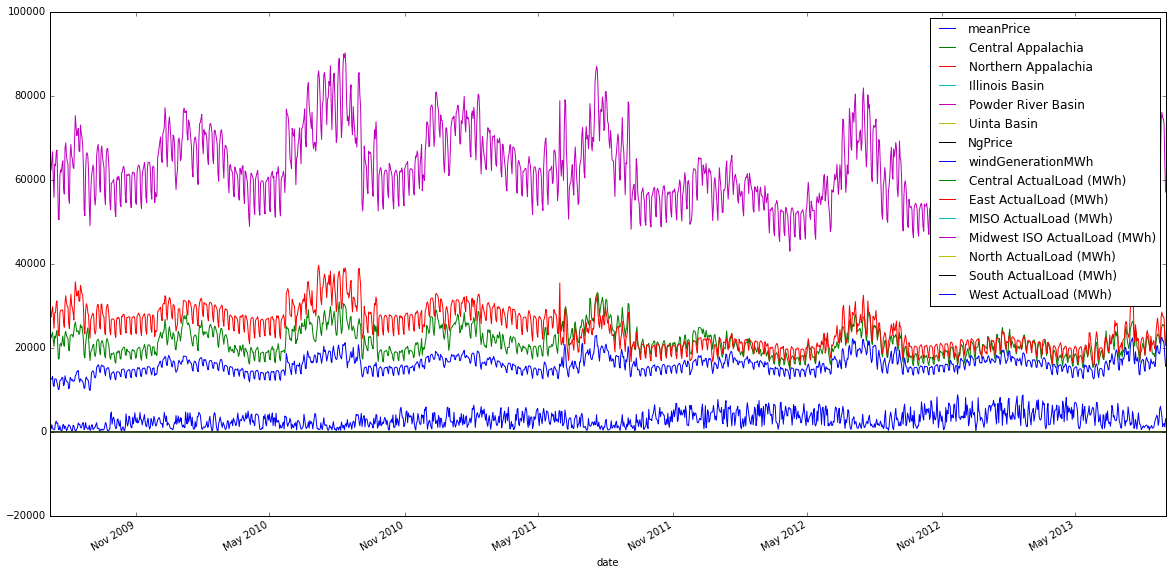

In [6]:
df = pd.merge(dfY, dfX, left_index=True, right_index=True, how='inner')
df = df[:'2013-09-01']
df.plot()

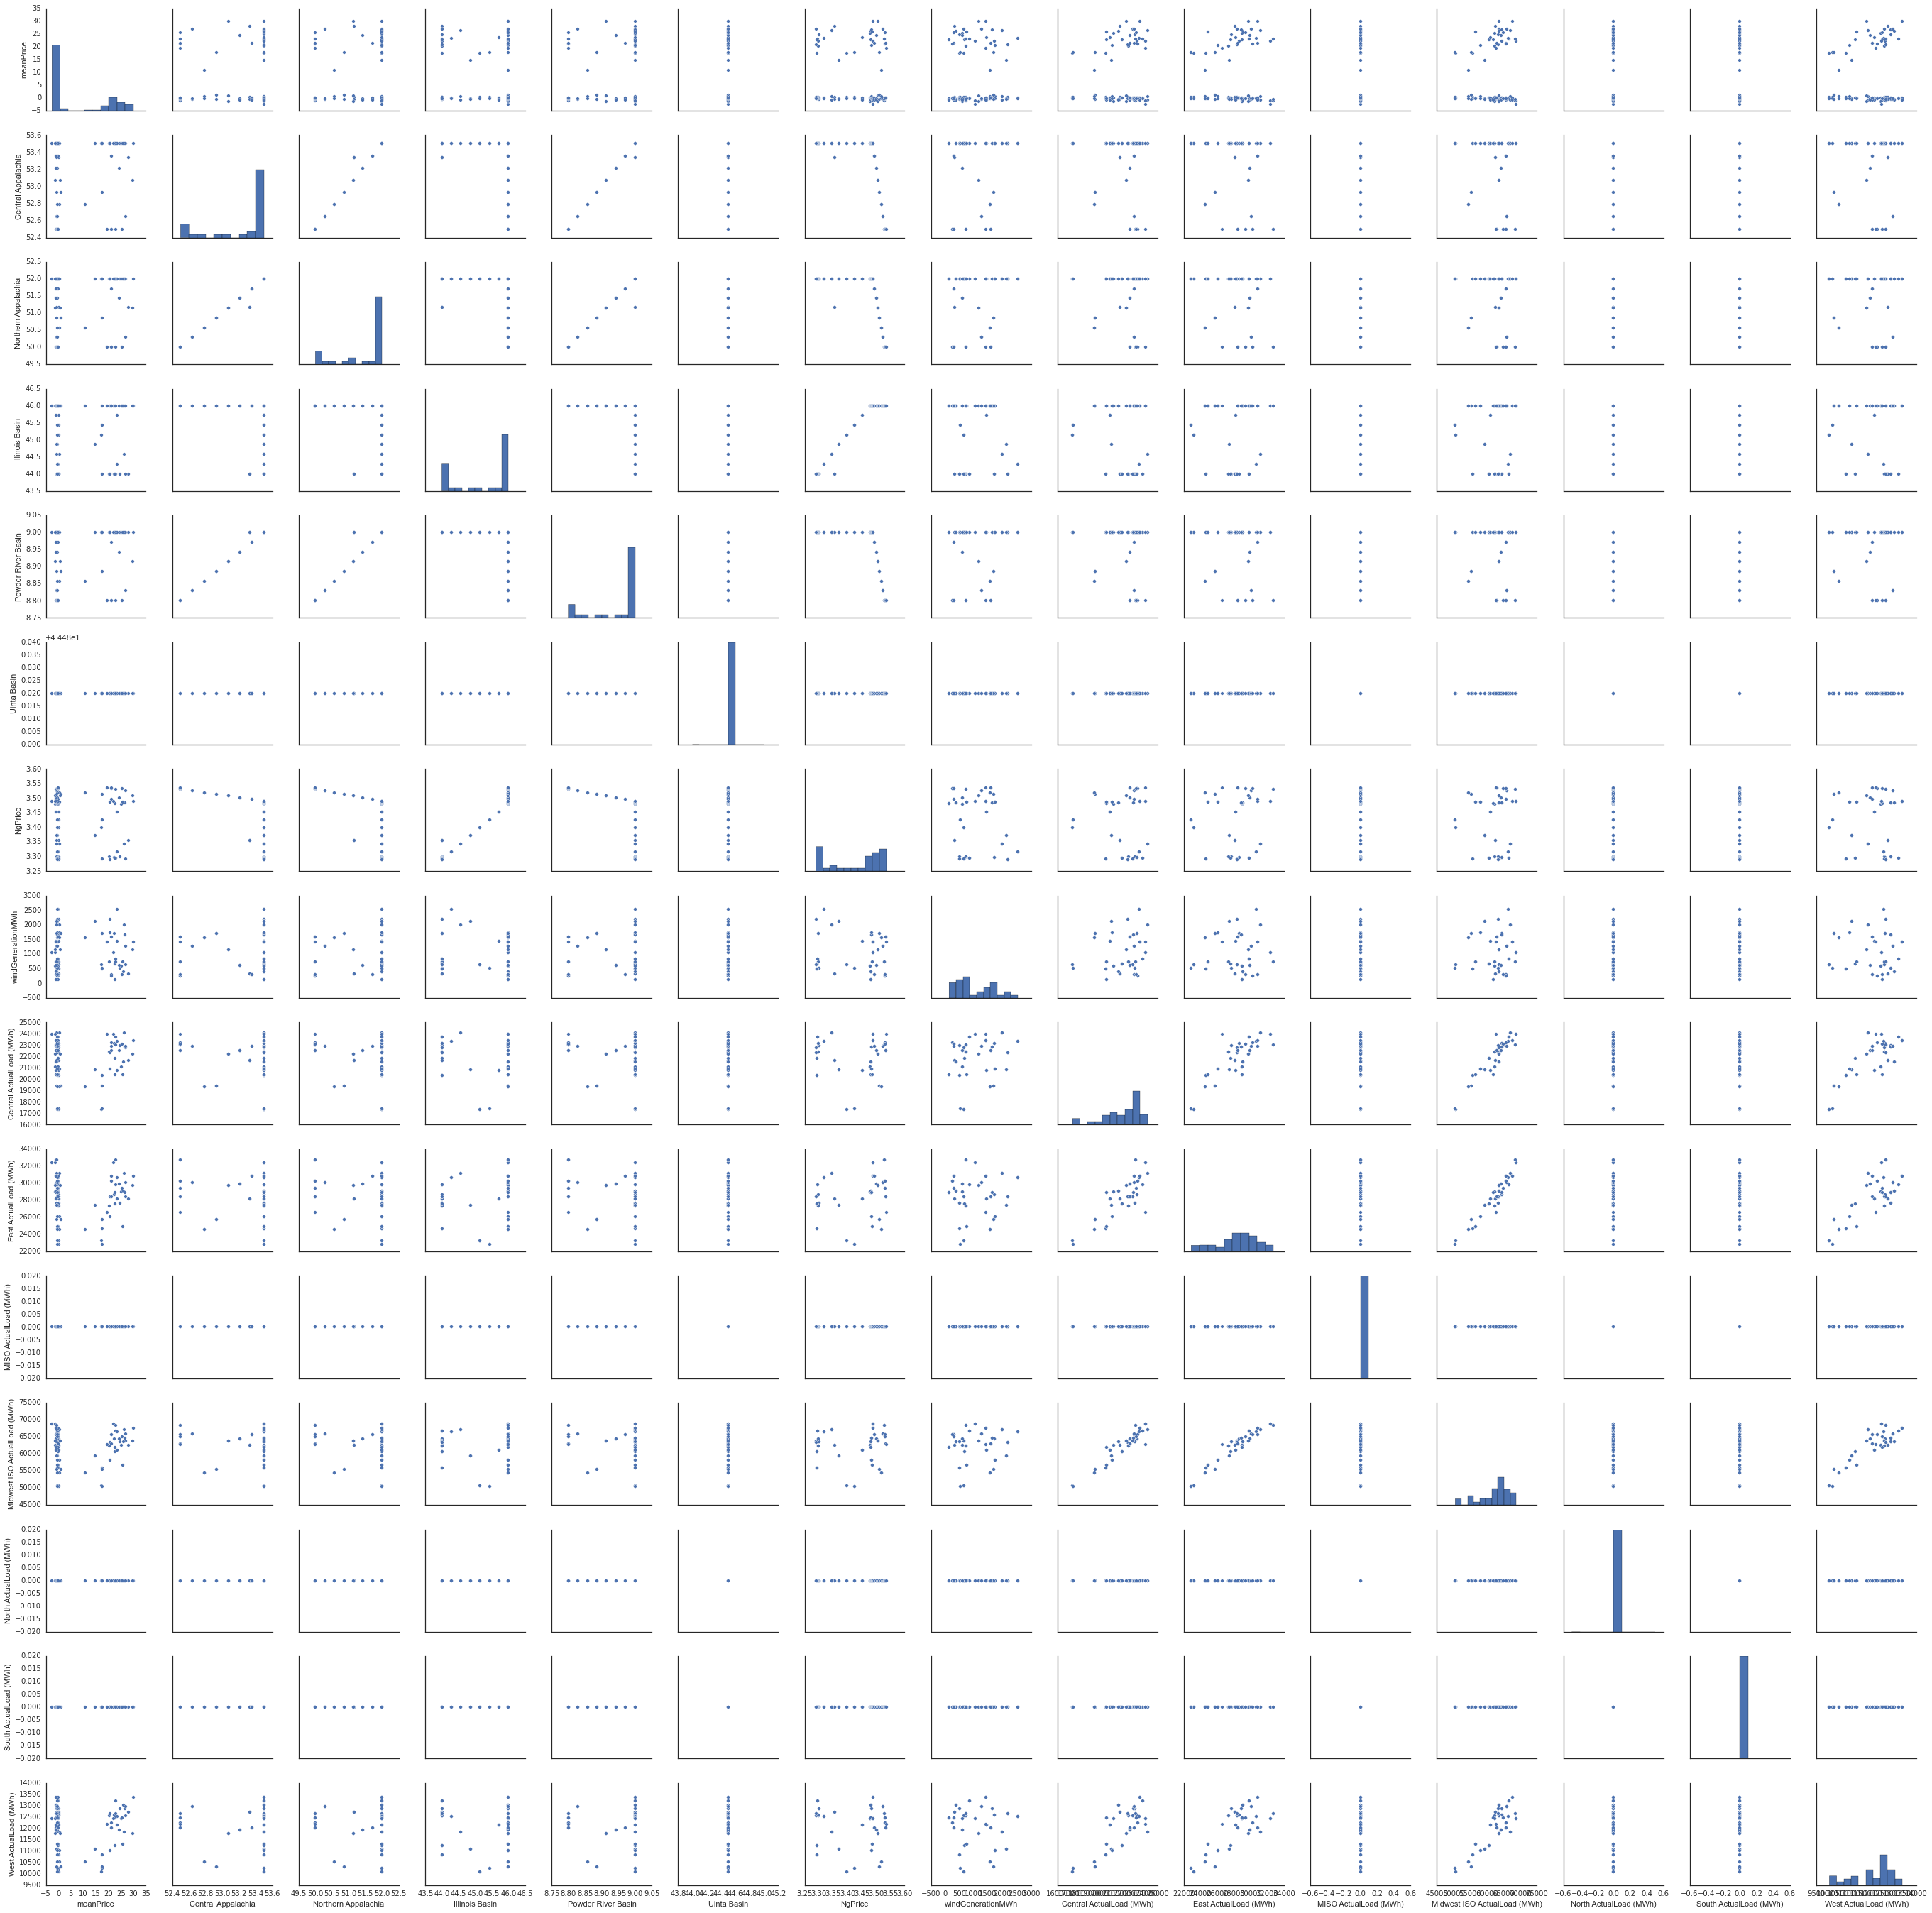

In [166]:
# import seaborn as sns
# sns.set_style('white')

# sns.pairplot(df[:100])

## Random Forest Regression

In [7]:
%%time

from sklearn.ensemble import RandomForestRegressor
from sklearn import grid_search

clf = grid_search.GridSearchCV(RandomForestRegressor(n_jobs=3), {
        'max_features': ['auto', 'sqrt', 'log2'],
        'n_estimators': [30,50,75,100],
        'max_depth': [None,1,2,3,5],
        'min_samples_split': [2,3,5]
    })
fit = clf.fit(df.drop('meanPrice', axis=1), df['meanPrice'])

print 'Params: ', fit.best_params_
print 'Score: ', fit.best_score_

Params:  {'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 50, 'max_depth': 2}
Score:  0.0168944570606
CPU times: user 2min 25s, sys: 6.93 s, total: 2min 32s
Wall time: 3min 6s


In [8]:
# Best Estimator
rf = fit.best_estimator_
print 'Score: ', rf.score(df.drop('meanPrice', axis=1), df['meanPrice'])

Score:  0.0308761185958


In [9]:
# Regression Coefficients
lcols = df.drop('meanPrice', axis=1).columns
pd.DataFrame(zip(lcols, rf.feature_importances_), columns=['Predictors', 'Feature Importances']).sort('Feature Importances', ascending=False)

/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,Predictors,Feature Importances
5,NgPrice,0.590691
7,Central ActualLoad (MWh),0.137241
10,Midwest ISO ActualLoad (MWh),0.131417
2,Illinois Basin,0.093959
1,Northern Appalachia,0.019870
13,West ActualLoad (MWh),0.012632
6,windGenerationMWh,0.007190
8,East ActualLoad (MWh),0.004917
3,Powder River Basin,0.002083
0,Central Appalachia,0.000000
